In [1]:
#%run hw2.py

In [1]:
import nltk
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Imports - our files
import utils
import models

# Global definitions - data
DATA_FN = 'data/crowdflower_data.csv'
LABEL_NAMES = ["happiness", "worry", "neutral", "sadness"]

# Global definitions - architecture
EMBEDDING_DIM = 100  # We will use pretrained 100-dimensional GloVe
BATCH_SIZE = 128
NUM_CLASSES = 4
USE_CUDA = torch.cuda.is_available()  # CUDA will be available if you are using the GPU image for this homework

# Global definitions - saving and loading data
FRESH_START = True  # set this to false after running once with True to just load your preprocessed data from file
#                     (good for debugging)
TEMP_FILE = "temporary_data.pkl"  # if you set FRESH_START to false, the program will look here for your data, etc.

In [2]:
# load the data and embeddings from file
try:
    with open(TEMP_FILE, "rb") as f:
        print("Loading DataLoaders and embeddings from file....")
        train_generator, dev_generator, test_generator, embeddings, train_data = pickle.load(f)
except FileNotFoundError:
    raise FileNotFoundError("You need to have saved your data with FRESH_START=True once in order to load it!")

Loading DataLoaders and embeddings from file....


In [19]:
# test embeddings
# ebs = nn.Embedding.from_pretrained(embeddings)
# train1 = ebs(train_batch)
# print(np.shape(train1))
# train11 = torch.sum(train1,dim=1)
# print(np.shape(train11))

torch.Size([128, 91, 100])
torch.Size([128, 100])


In [46]:
class DenseNetwork(nn.Module):
    def __init__(self, embed_dim, output_dim, hidden_dim, weight):
        super(DenseNetwork, self).__init__()

        ########## YOUR CODE HERE ##########
        # TODO: Here, create any layers and attributes your network needs.
        self.embedding = nn.Embedding.from_pretrained(weight)
        self.dense1 = nn.Linear(embed_dim, hidden_dim) 
        self.dense2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()     

    def forward(self, x):
        ########## YOUR CODE HERE ##########
        # TODO: Fill in the forward pass of your neural network.
        # TODO: (The backward pass will be performed by PyTorch magic for you!)
        # TODO: Your architecture should...
        # TODO: 1) Put the words through an Embedding layer (which was initialized with the pretrained embeddings);
        x = self.embedding(x)
        # TODO: 2) Take the sum of all word embeddings in a sentence
        x = torch.sum(x,dim=1).float()
        # TODO: 3) Feed the result into 2-layer feedforward network which produces a 4-vector of values,
        # TODO: one for each class
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        return x
        
net = DenseNetwork(EMBEDDING_DIM, NUM_CLASSES, 64, embeddings)
print(net)

DenseNetwork(
  (embedding): Embedding(17635, 100)
  (dense1): Linear(in_features=100, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
)


In [37]:
np.shape(net(train_batch))

torch.Size([128, 100])


torch.Size([128, 4])

In [70]:
HIDDEN_DIM = 64
model = DenseNetwork(EMBEDDING_DIM, NUM_CLASSES, HIDDEN_DIM, embeddings)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
  
EPOCHS = 20
losses = []
for iepoch in range(EPOCHS): 
    for train_batch, train_label in train_generator:
        # Compute and print loss
        loss = criterion(model(train_batch),train_label)
        #print(loss.item()) 

        # Zero the gradients
        model.zero_grad()

        # perform a backward pass (backpropagation)
        loss.backward()

        # Update the parameters
        optimizer.step()

    total_loss = 0
    for ibatch, ilabel in dev_generator:
        dev_loss = criterion(model(ibatch), ilabel)
        total_loss += dev_loss
    print(iepoch, total_loss)
    losses.append(total_loss)

0 tensor(27.9350, grad_fn=<AddBackward0>)
1 tensor(27.3739, grad_fn=<AddBackward0>)
2 tensor(27.0554, grad_fn=<AddBackward0>)
3 tensor(26.8350, grad_fn=<AddBackward0>)
4 tensor(26.5253, grad_fn=<AddBackward0>)
5 tensor(25.8699, grad_fn=<AddBackward0>)
6 tensor(25.6448, grad_fn=<AddBackward0>)
7 tensor(25.5283, grad_fn=<AddBackward0>)
8 tensor(25.5029, grad_fn=<AddBackward0>)
9 tensor(25.4591, grad_fn=<AddBackward0>)
10 tensor(25.4942, grad_fn=<AddBackward0>)
11 tensor(25.4476, grad_fn=<AddBackward0>)
12 tensor(25.4547, grad_fn=<AddBackward0>)
13 tensor(25.4571, grad_fn=<AddBackward0>)
14 tensor(25.4687, grad_fn=<AddBackward0>)
15 tensor(25.4762, grad_fn=<AddBackward0>)
16 tensor(25.4888, grad_fn=<AddBackward0>)
17 tensor(25.4845, grad_fn=<AddBackward0>)
18 tensor(25.6559, grad_fn=<AddBackward0>)
19 tensor(25.6036, grad_fn=<AddBackward0>)


ModuleNotFoundError: No module named 'matplotlib'

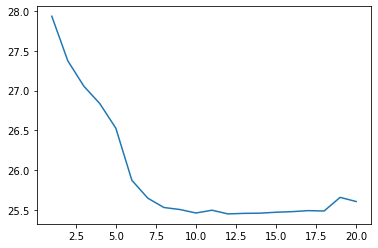

In [76]:
import matplotlib.pyplot as plt
x = np.arange(1,EPOCHS+1)
plt.plot(x, losses)
plt.show()

In [17]:
np.shape(embeddings)

torch.Size([17635, 100])

In [15]:
train_generator

In [ ]:
def train_model(model, loss_fn, optimizer, train_generator, dev_generator):
    """
    Perform the actual training of the model based on the train and dev sets.
    :param model: one of your models, to be trained to perform 4-way emotion classification
    :param loss_fn: a function that can calculate loss between the predicted and gold labels
    :param optimizer: a created optimizer you will use to update your model weights
    :param train_generator: a DataLoader that provides batches of the training set
    :param dev_generator: a DataLoader that provides batches of the development set
    :return model, the trained model
    """
    
    
    for epoch in range(50):
        # Forward Propagation
        y_pred = model(x)
        # Compute and print loss
        loss = criterion(y_pred, y)
        print('epoch: ', epoch,' loss: ', loss.item())
        # Zero the gradients
        optimizer.zero_grad()

        # perform a backward pass (backpropagation)
        loss.backward()

        # Update the parameters
        optimizer.step()

In [233]:
import torch.autograd as autograd
class RecurrentNetwork(nn.Module):
    def __init__(self, sentence_len, output_dim, hidden_dim, weight):
        super(RecurrentNetwork, self).__init__()
        ########## YOUR CODE HERE ##########
        # TODO: Here, create any layers and attributes your network needs.
        self.embedding = nn.Embedding.from_pretrained(weight)
        self.sentence_len = sentence_len
        self.embed_dim = np.shape(weight)[1]  
        # Define hidden dim
        self.hidden_dim = hidden_dim
        # Define 2-layer LSTM
        self.lstm = nn.LSTM(self.embed_dim, self.hidden_dim,num_layers=2) 
        #self.lstm2 = nn.LSTM(hidden_dim, output_dim)
        # Define final transform layer
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU() 

        
    # x is a PaddedSequence for an RNN
    def forward(self, x):
        ########## YOUR CODE HERE ##########
        # TODO: 1) Put the words through an Embedding layer (which was initialized with the pretrained embeddings);
        batch_size = np.shape(x)[0]
        if np.shape(x)[1] != self.sentence_len:
            x = self.pad(x)
        mid = self.embedding(x).float()
        # TODO: 2) Feed the sequence of embeddings through a 2-layer RNN
        mid = mid.view(self.sentence_len, batch_size, -1)
        # Add hidden layer
        self.hidden = self.initialize_hidden(x)
        out, _ = self.lstm(mid, self.hidden)
        # TODO: 3) Feed the last output state into a dense layer to become a 4-vector of values, one for each class    
        out = self.linear(out[-1].view(batch_size, -1))
        return self.relu(out)
        
    def initialize_hidden(self,x):
        # n_layers * n_directions, batch_size, rnn_hidden_size
        batch_size = np.shape(x)[0]
        return (autograd.Variable(torch.zeros(2, batch_size, self.hidden_dim)),
               autograd.Variable(torch.zeros(2, batch_size, self.hidden_dim)))
    
    def pad(self, x):
        if np.shape(x)[1] > self.sentence_len:
            return x[:,:self.sentence_len]
        elif np.shape(x)[1] < self.sentence_len:
            tmp = torch.zeros(np.shape(x)[0], self.sentence_len-np.shape(x)[1], dtype=torch.long)
            return torch.cat((x,tmp), 1)
        
net = RecurrentNetwork(91, NUM_CLASSES, 64, embeddings)
print(net)

RecurrentNetwork(
  (embedding): Embedding(17635, 100)
  (lstm): LSTM(100, 64, num_layers=2)
  (linear): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
)


In [246]:
class RecurrentNetwork2(nn.Module):
    def __init__(self, sentence_len, output_dim, hidden_dim, weight):
        super(RecurrentNetwork2, self).__init__()
        ########## YOUR CODE HERE ##########
        # TODO: Here, create any layers and attributes your network needs.
        # Define dimensions
        self.sentence_len = sentence_len
        self.embed_dim = weight.size(1) 
        self.hidden_dim = hidden_dim
        # Define embeddings
        self.embedding = nn.Embedding.from_pretrained(weight)
        # Define 2-layer LSTM
        self.lstm = nn.LSTM(self.embed_dim, self.hidden_dim,num_layers=2) 
        # Define final dense layer
        self.linear = nn.Linear(hidden_dim, output_dim)

    # x is a PaddedSequence for an RNN
    def forward(self, x):
        ########## YOUR CODE HERE ##########
        # TODO: 1) Put the words through an Embedding layer (which was initialized with the pretrained embeddings);
        batch_size = x.size(0)
        if x.size(1) != self.sentence_len:
            x = self.pad(x)
        mid = self.embedding(x).float()
        # TODO: 2) Feed the sequence of embeddings through a 2-layer RNN
        out, _ = self.lstm(mid.view(self.sentence_len, batch_size, -1))
        # TODO: 3) Feed the last output state into a dense layer to become a 4-vector of values, one for each class    
        out = self.linear(out[-1].view(batch_size, -1))
        return out
    
    def pad(self, x):
        if x.size(1) > self.sentence_len:
            return x[:,:self.sentence_len]
        elif x.size(1) < self.sentence_len:
            tmp = torch.zeros(x.size(0), self.sentence_len-x.size(1), dtype=torch.long)
            return torch.cat((x,tmp), 1)
        
net = RecurrentNetwork2(91, NUM_CLASSES, 64, embeddings)
print(net)

RecurrentNetwork2(
  (embedding): Embedding(17635, 100)
  (lstm): LSTM(100, 64, num_layers=2)
  (linear): Linear(in_features=64, out_features=4, bias=True)
)


In [247]:
HIDDEN_DIM = 64
SENTENCE_LEN = 91
model3 = RecurrentNetwork2(SENTENCE_LEN, NUM_CLASSES, HIDDEN_DIM, embeddings)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters())
  
EPOCHS = 20
losses = []
for iepoch in range(EPOCHS): 
    for train_batch, train_label in train_generator:
        # Compute and print loss
        loss = criterion(model3(train_batch),train_label)
        #print(loss.item()) 

        # Zero the gradients
        model3.zero_grad()

        # perform a backward pass (backpropagation)
        loss.backward()

        # Update the parameters
        optimizer.step()

    total_loss = 0
    for ibatch, ilabel in dev_generator:
        dev_loss = criterion(model3(ibatch), ilabel)
        total_loss += dev_loss
    print(iepoch, total_loss)
    losses.append(total_loss)

0 tensor(29.9571, grad_fn=<AddBackward0>)
1 tensor(29.9643, grad_fn=<AddBackward0>)
2 tensor(29.9784, grad_fn=<AddBackward0>)
3 tensor(30.0040, grad_fn=<AddBackward0>)
4 tensor(30.0389, grad_fn=<AddBackward0>)
5 tensor(30.0773, grad_fn=<AddBackward0>)
6 tensor(30.1187, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [235]:
test_model(model2, criterion, test_generator)

Test loss: 
tensor([31.3124])
F-score: 
0.241271458015108


In [248]:
test_model(model3, criterion, test_generator)

Test loss: 
tensor([30.0885])
F-score: 
0.20516519559165525


In [ ]:
seq, len_seq = nn.utils.rnn.pad_packed_sequence()

In [334]:
embedding = nn.Embedding.from_pretrained(embeddings)
x = embedding(ibatch).float()
h0 = Variable(torch.zeros(2, x.size(0), 64))

In [335]:
rnn = nn.RNN(100, 64, 2, batch_first=True)
out, _ = rnn(x, h0)

In [264]:
np.shape(out)

torch.Size([88, 91, 64])

In [267]:
np.shape(ibatch)

torch.Size([59, 82])

In [284]:
seq_lengths = torch.LongTensor([len(seq) for seq in ibatch])

In [285]:
seq_lengths

tensor([82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82,
        82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82,
        82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82,
        82, 82, 82, 82, 82])

In [309]:
seq_tensor = torch.zeros((ibatch.size(0), 91))#.long().cuda()
for idx, (seq, seqlen) in enumerate(zip(ibatch, seq_lengths)):
    seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
print(np.shape(seq_tensor))
embedding(seq_tensor).float()

torch.Size([59, 91])


RuntimeError: Expected tensor for argument #1 'indices' to have scalar type Long; but got torch.FloatTensor instead (while checking arguments for embedding)

In [306]:
seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
seq_tensor = seq_tensor[perm_idx]

In [322]:
(ibatch == 0).nonzero()[0]

tensor([ 0, 22])

In [328]:
len_seq =  torch.LongTensor([(seq==0).nonzero()[0] for seq in ibatch])

In [329]:
len_seq

tensor([22, 28, 20, 23, 32,  4, 15, 14, 15,  4, 17,  3,  5, 18, 16, 28, 21, 27,
        20, 19, 24, 19, 30, 18,  6,  8, 16,  7,  7, 19, 22, 14, 15,  7, 31, 15,
        20, 20, 23, 15, 17, 22, 14, 30,  9, 19, 19, 17, 21, 27, 12,  2, 20,  6,
        12, 15, 18, 10,  7])

In [333]:
nn.utils.rnn.pack_padded_sequence(ibatch,len_seq,batch_first=True,enforce_sorted=False)

ValueError: only one element tensors can be converted to Python scalars

In [307]:
embedding = nn.Embedding.from_pretrained(embeddings)
print(np.shape(seq_tensor))
embedding = nn.Embedding.from_pretrained(embeddings)
seq_tensor = embedding(seq_tensor).float()
seq_tensor = seq_tensor.transpose(0,1)
packed_input = pack_padded_sequence(seq_tensor, seq_lengths.float())

torch.Size([59, 59])


RuntimeError: Expected tensor for argument #1 'indices' to have scalar type Long; but got torch.FloatTensor instead (while checking arguments for embedding)

In [282]:
iseq = nn.utils.rnn.pack_padded_sequence(ibatch,seq_lengths,batch_first=True)

In [283]:
np.shape(iseq.data)

torch.Size([4838])

In [275]:
test,length = nn.utils.rnn.pad_packed_sequence(ibatch,batch_first=True, padding_value=0.0)

AttributeError: 'Tensor' object has no attribute 'batch_sizes'

In [265]:
nn.utils.rnn.pack_padded_sequence(out)

TypeError: pack_padded_sequence() missing 1 required positional argument: 'lengths'

In [336]:
x_length = [ibatch.size(1)]*ibatch.size(0)
ibatch = embedding(ibatch)

In [347]:
def pad(x, sentence_len):
    if x.size(1) > sentence_len:
        return x[:,:sentence_len,:].transpose(0,1)
    elif x.size(1) < sentence_len:
        padded_x = np.zeros((sentence_len,x.size(0),100))
        
        tmp = torch.zeros(x.size(0), sentence_len-x.size(1),100, dtype=torch.long)
        print(tmp.size(),x.size())
        return torch.cat((x.transpose(0,1),tmp.transpose(0,1)))

In [346]:
torch.cat((torch.zeros(,ibatch.transpose(0,1)))
ibatch.transpose(0,1).size()

torch.Size([82, 59, 100])

In [348]:
mid = pad(ibatch,91)
mid.size()

torch.Size([59, 9, 100]) torch.Size([59, 82, 100])


RuntimeError: Expected object of scalar type Double but got scalar type Long for sequence element 1 in sequence argument at position #1 'tensors'

In [383]:
# different rnn
from torch.autograd import Variable
class RNNModel(nn.Module):
    def __init__(self, sentence_len, output_dim,hidden_dim, layer_dim,weight):
        super(RNNModel, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        self.sentence_len = sentence_len
        self.embed_dim = weight.size(1) 
        
        # Define embeddings
        self.embedding = nn.Embedding.from_pretrained(weight)
        
        # RNN
        self.rnn = nn.RNN(self.embed_dim, hidden_dim, layer_dim, batch_first=True)
        
        #self.drop_layer = nn.Dropout(0.5)
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        batch_size = x.size(0)
        if x.size(1) != self.sentence_len:
            x_lengths, x = self.pad(x) 
            x = self.embedding(x).float()
            x = nn.utils.rnn.pack_padded_sequence(x, x_lengths, batch_first=True)
            # Initialize hidden state with zeros
            #h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

            # One time step
            out, _ = self.rnn(x)
            #out = self.drop_layer(out)
            print(np.shape(out))
            out, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
            print(np.shape(out))
            out = out.contiguous()[:,-1,:]
            print(np.shape(out))
            out = self.fc(out)
        else:
            x = self.embedding(x).float()
            out, _ = self.rnn(x)
            out = self.fc(out[:, -1, :]) 
        return out
    
    def pad(self, x):
        if x.size(1) > self.sentence_len:
            return [len(ix) for ix in x], x[:,:self.sentence_len]
        elif x.size(1) < self.sentence_len:
            x_lengths = [len(ix) for ix in x]
            padded_x = torch.zeros(x.size(0), self.sentence_len, dtype=torch.long)
            # copy over the actual sequences
            for i, x_len in enumerate(x_lengths):
                sequence = x[i]
                padded_x[i, 0:x_len] = sequence[:x_len]
            return x_lengths, padded_x
net = RNNModel(91, NUM_CLASSES, 64,2, embeddings)
print(net)

RNNModel(
  (embedding): Embedding(17635, 100)
  (rnn): RNN(100, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)


In [385]:
HIDDEN_DIM = 64
SENTENCE_LEN = 91
model3 = RNNModel(SENTENCE_LEN, NUM_CLASSES, HIDDEN_DIM,2, embeddings)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters())
  
EPOCHS = 20
losses = []
for iepoch in range(EPOCHS): 
    i = 0
    for train_batch, train_label in train_generator:
        if i>10:
            break
        i += 1
        # Compute and print loss
        loss = criterion(model3(train_batch),train_label)
        print(loss.item()) 

        # Zero the gradients
        model3.zero_grad()

        # perform a backward pass (backpropagation)
        loss.backward()

        # Update the parameters
        optimizer.step()

    total_loss = 0
    for ibatch, ilabel in dev_generator:
        dev_loss = criterion(model3(ibatch), ilabel)
        total_loss += dev_loss
    print(iepoch, total_loss)
    losses.append(total_loss)

1.39463210105896
1.3888366222381592
1.3748220205307007
1.3817405700683594
1.3644577264785767
1.3414642810821533
1.3237872123718262
1.3141095638275146
1.383470892906189
1.396377682685852
1.348715901374817
(4,)
torch.Size([128, 82, 100])
torch.Size([128, 100])


RuntimeError: size mismatch, m1: [128 x 100], m2: [64 x 4] at ../aten/src/TH/generic/THTensorMath.cpp:752

In [361]:
def pad(x, sentence_len=91):
    if x.size(1) > sentence_len:
        return [len(ix) for ix in x], x[:,:sentence_len]
    elif x.size(1) < sentence_len:
        x_lengths = [len(ix) for ix in x]
        padded_x = torch.zeros(x.size(0), sentence_len, dtype=torch.long)
        # copy over the actual sequences
        for i, x_len in enumerate(x_lengths):
            sequence = x[i]
            padded_x[i, 0:x_len] = sequence[:x_len]
        return x_lengths, padded_x

In [362]:
ibatch.size()

torch.Size([128, 82])

In [375]:
l,ie = pad(ibatch)
print(ie.size())
ie = embedding(ie).float()
x = nn.utils.rnn.pack_padded_sequence(ie, l, batch_first=True)
# Initialize hidden state with zeros
#h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

# One time step
out, _ = rnn(x)
#out = self.drop_layer(out)
out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
out = out.contiguous()[:,-1,:]
print(np.shape(out))
fc = nn.Linear(64,4)
out = fc(out)
print(np.shape(out))

torch.Size([128, 91])
torch.Size([128, 64])
torch.Size([128, 4])


In [ ]:
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden  

In [77]:
def test_model(model, loss_fn, test_generator):
    """
    Evaluate the performance of a model on the development set, providing the loss and macro F1 score.
    :param model: a model that performs 4-way emotion classification
    :param loss_fn: a function that can calculate loss between the predicted and gold labels
    :param test_generator: a DataLoader that provides batches of the testing set
    """
    gold = []
    predicted = []

    # Keep track of the loss
    loss = torch.zeros(1)  # requires_grad = False by default; float32 by default
    if USE_CUDA:
        loss = loss.cuda()

    model.eval()

    # Iterate over batches in the test dataset
    with torch.no_grad():
        for X_b, y_b in test_generator:
            # Predict
            y_pred = model(X_b)

            # Save gold and predicted labels for F1 score - take the argmax to convert to class labels
            gold.extend(y_b.cpu().detach().numpy())
            predicted.extend(y_pred.argmax(1).cpu().detach().numpy())

            loss += loss_fn(y_pred.double(), y_b.long()).data

    # Print total loss and macro F1 score
    print("Test loss: ")
    print(loss)
    print("F-score: ")
    print(f1_score(gold, predicted, average='macro'))

test_model(model, criterion, test_generator)

Test loss: 
tensor([25.9427])
F-score: 
0.45296065571667343
